# Prepare Freesurfer Miscrostrcutural maps

This notebook loads individual freesurfer-derived microstructural maps (e.g. cortical thickness, curvature and T1/T2 as proxy for myelin) and concatenates them into a single file.

**Inputs**

Indiviudal microstructural maps<br>
`{subj}/MNINonLinear/fsaverage_LR32k/{subj}.{map_type}_MSMAll.32k_fs_LR.dscalar.nii` 

**Outputs**

Single HCP microstructure file (containing data for all 254 subjects)<br>
`/scratch/users/robert.scholz2/acc_dists/all_fs_struct_254_full_unrelated.L.npy`

<br>

In [1]:
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import os
import hcp_utils as hcp
import nibabel as nib
nib.imageglobals.logger.setLevel(40)

f= lambda str: eval("f'" + f"{str}" + "'")

from lib.plotting import plot_29k

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
len(full_subjs), full_subjs[:4]

(254, array(['100206', '100610', '101006', '101309'], dtype='<U21'))

In [11]:
# Definition of which microstructure files to download
from lib.default_config import structural_file_templates 
"""
structural_file_templates = [
  "{subj}/MNINonLinear/fsaverage_LR32k/{subj}.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii",
  "{subj}/MNINonLinear/fsaverage_LR32k/{subj}.corrThickness_MSMAll.32k_fs_LR.dscalar.nii",
  "{subj}/MNINonLinear/fsaverage_LR32k/{subj}.curvature_MSMAll.32k_fs_LR.dscalar.nii",
  "{subj}/MNINonLinear/fsaverage_LR32k/{subj}.sulc_MSMAll.32k_fs_LR.dscalar.nii",
  "{subj}/MNINonLinear/fsaverage_LR32k/{subj}.thickness_MSMAll.32k_fs_LR.dscalar.nii"]
""";

## Single subject sample download and plotting

 File exists locally already. Not overwriting. 
(1, 59412) 100206/MNINonLinear/fsaverage_LR32k/100206.MyelinMap_MSMAll.32k_fs_LR.dscalar.nii


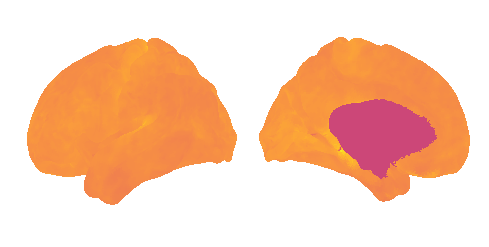

In [19]:
# Example download of a single microstructure file from HCP via AWS
from lib.aws_tools import download_aws_file, exists_locally_or_on_aws
file= f"{subj}/MNINonLinear/fsaverage_LR32k/{subj}.MyelinMap_MSMAll.32k_fs_LR.dscalar.nii"
local_path = download_aws_file("HCP_1200/" + file);
data = nib.load(local_path).get_fdata()[hcp.struct.cortex_left]
print(data.shape, file)
plot_29k(data[0], cmap="plasma", colorbar=None)

In [32]:
# Show the files and shapes of a sample subjects microstructure maps
subj = full_subjs[0]
local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"
for sf in structural_file_templates: 
  file = local_hcp_dir + f(sf)
  data = nib.load(file).get_fdata()[hcp.struct.cortex_left]
  print(data.shape, file.split("/")[-1])

(1, 59412) 100206.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii
(1, 59412) 100206.corrThickness_MSMAll.32k_fs_LR.dscalar.nii
(1, 59412) 100206.curvature_MSMAll.32k_fs_LR.dscalar.nii
(1, 59412) 100206.sulc_MSMAll.32k_fs_LR.dscalar.nii
(1, 59412) 100206.thickness_MSMAll.32k_fs_LR.dscalar.nii


In [ ]:
# This can be summarized into a loading function
load_struc = lambda sf: \
   nib.load(local_hcp_dir + f(sf)).get_fdata()[:,hcp.struct.cortex_left]

(5, 29696)


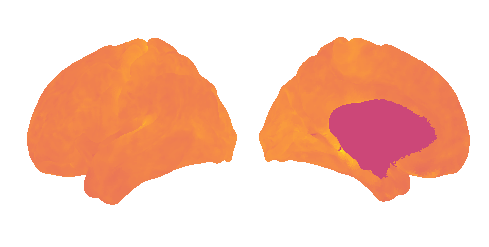

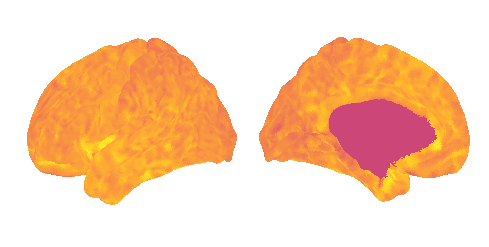

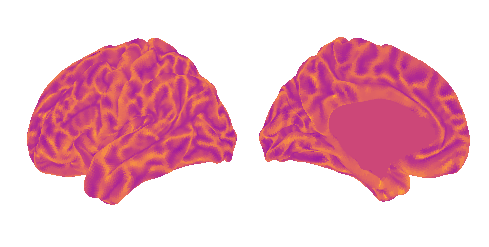

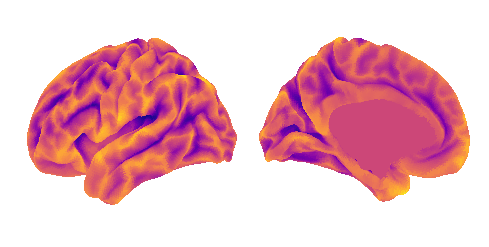

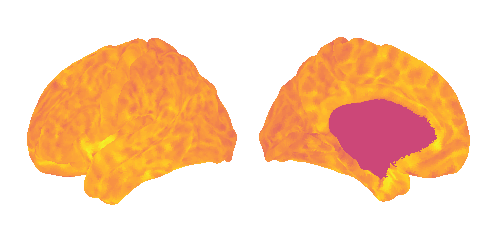

In [34]:
# Display examples of structural maps for a single subject
cdata = np.concatenate([load_struc(sf) for sf in structural_file_templates])
print(cdata.shape)
for x in range(cdata.shape[0]): plot_29k(cdata[x], cmap="plasma", colorbar=None)

## Batch loading and saving of microstrcuture maps for all subjects

In [17]:
local_hcp_dir ="/scratch/users/robert.scholz2/HCP_1200/"
load_struc = lambda sf: nib.load(local_hcp_dir + f(sf)).get_fdata()[:,hcp.struct.cortex_left]
fs_structmaps = {}

for subj in tqdm(full_subjs, desc="Loading ..."):  
  cdata = np.concatenate([load_struc(sf) for sf in structural_file_templates])
  fs_structmaps[subj] = cdata.astype(np.float32).T; # final shape: (5, 29696)

Loading ...: 100%|██████████| 254/254 [03:26<00:00,  1.23it/s]


In [4]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_fs_struct_254_full_unrelated.L.npy"
np.save(fn, fs_structmaps)
!ls -ash {fn}

144M /scratch/users/robert.scholz2/acc_dists/all_fs_struct_254_full_unrelated.L.npy
